Student 1 : ORTEGA Marius \
Student 2 : TEILLET Louis 

# Libraries

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import river
from river import stream
from river.ensemble import AdaBoostClassifier
from river.forest import AMFClassifier
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.drift import DriftRetrainingClassifier
from river.preprocessing import Binarizer, OneHotEncoder, StandardScaler
from river import compose
from river import metrics
from river import evaluate

In [16]:
for x, y in stream.iter_arff("covtypeNorm.arff", target="class"):
    print("Variables: ", x, "\nLabel    : ", y)
    break

Variables:  {'Elevation': 0.368684, 'Aspect': 0.141667, 'Slope': 0.045455, 'Horizontal_Distance_To_Hydrology': 0.184681, 'Vertical_Distance_To_Hydrology': 0.223514, 'Horizontal_Distance_To_Roadways': 0.071659, 'Hillshade_9am': 0.870079, 'Hillshade_Noon': 0.913386, 'Hillshade_3pm': 0.582677, 'Horizontal_Distance_To_Fire_Points': 0.875366, 'Wilderness_Area1': '1', 'Wilderness_Area2': '0', 'Wilderness_Area3': '0', 'Wilderness_Area4': '0', 'Soil_Type1': '0', 'Soil_Type2': '0', 'Soil_Type3': '0', 'Soil_Type4': '0', 'Soil_Type5': '0', 'Soil_Type6': '0', 'Soil_Type7': '0', 'Soil_Type8': '0', 'Soil_Type9': '0', 'Soil_Type10': '0', 'Soil_Type11': '0', 'Soil_Type12': '0', 'Soil_Type13': '0', 'Soil_Type14': '0', 'Soil_Type15': '0', 'Soil_Type16': '0', 'Soil_Type17': '0', 'Soil_Type18': '0', 'Soil_Type19': '0', 'Soil_Type20': '0', 'Soil_Type21': '0', 'Soil_Type22': '0', 'Soil_Type23': '0', 'Soil_Type24': '0', 'Soil_Type25': '0', 'Soil_Type26': '0', 'Soil_Type27': '0', 'Soil_Type28': '0', 'Soil_Typ

#### Tools

In [17]:
def print_progress(sample_id, acc, kappa, f1, precision, recall):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)
    print(f1)
    print(precision)
    print(recall)

def evaluate(stream, model, numericals, categoricals, n_wait=1000, max_iter=2000, verbose=False):
    acc = metrics.Accuracy()
    kappa = metrics.CohenKappa()
    f1 = metrics.MicroF1()
    precision = metrics.MicroPrecision()
    recall = metrics.MicroRecall()

    scaler = compose.Select(*numericals) | StandardScaler()

    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        
        if i >= max_iter+1:
            break
        # Predict
        #x_cat = binanizer.learn_one(x).transform_one(x)
        x_cat = {k: int(v) for k, v in x.items() if k in categoricals}
        x_num = scaler.learn_one(x).transform_one(x)
        x = {**x_num, **x_cat}
        
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        f1.update(y_true=y, y_pred=y_pred)
        precision.update(y_true=y, y_pred=y_pred)
        recall.update(y_true=y, y_pred=y_pred)
        
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa, f1, precision, recall)
            raw_results.append([model_name, i, 
                                acc.get(),
                                kappa.get(), 
                                f1.get(), 
                                precision.get(),
                                recall.get()])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, acc, kappa, f1, precision, recall)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'kappa', 'f1', 'precision', 'recall'])

### 2. Classifiers performance comparison

In this study, we selected 5 classifiers to compare their performance. The classifiers are the following : 
- Emsemble method : AdaBoostClassifier
- Forest : AMFClassifier
- Trees : HoeffdingTreeClassifier
- Neighbors : KNNClassifier
- Drift : DriftRetrainingClassifier

#### Utils

In [18]:
numericals = list(x.keys())[:10]
categoricals = list(x.keys())[10:54]
n_iter = 50000

#### 2.1. AdaBoostClassifier

In [19]:
ada = AdaBoostClassifier(model=HoeffdingTreeClassifier(), n_models=10, seed=56)

ada_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), ada, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
ada_perf

Samples processed: 50001
Accuracy: 74.69%
CohenKappa: 56.25%
MicroF1: 74.69%
MicroPrecision: 74.69%
MicroRecall: 74.69%


,model,id,acc,kappa,f1,precision,recall
0,AdaBoostClassifier,1000,0.625375,0.314633,0.625375,0.625375,0.625375
1,AdaBoostClassifier,2000,0.572214,0.360015,0.572214,0.572214,0.572214
2,AdaBoostClassifier,3000,0.475175,0.311805,0.475175,0.475175,0.475175
3,AdaBoostClassifier,4000,0.400150,0.256295,0.400150,0.400150,0.400150
4,AdaBoostClassifier,5000,0.355329,0.223666,0.355329,0.355329,0.355329
5,AdaBoostClassifier,6000,0.344109,0.224549,0.344109,0.344109,0.344109
6,AdaBoostClassifier,7000,0.346808,0.226904,0.346808,0.346808,0.346808
7,AdaBoostClassifier,8000,0.376953,0.266517,0.376953,0.376953,0.376953
8,AdaBoostClassifier,9000,0.392623,0.285106,0.392623,0.392623,0.392623
9,AdaBoostClassifier,10000,0.417758,0.318877,0.417758,0.417758,0.417758


#### 2.2. AMFClassifier

In [20]:
amf = AMFClassifier(seed=56)

amf_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), amf, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
amf_perf

Samples processed: 50001
Accuracy: 89.74%
CohenKappa: 83.19%
MicroF1: 89.74%
MicroPrecision: 89.74%
MicroRecall: 89.74%


,model,id,acc,kappa,f1,precision,recall
0,AMFClassifier,1000,0.773227,0.574284,0.773227,0.773227,0.773227
1,AMFClassifier,2000,0.787106,0.689937,0.787106,0.787106,0.787106
2,AMFClassifier,3000,0.804732,0.751990,0.804732,0.804732,0.804732
3,AMFClassifier,4000,0.823544,0.785833,0.823544,0.823544,0.823544
4,AMFClassifier,5000,0.822436,0.783844,0.822436,0.822436,0.822436
5,AMFClassifier,6000,0.814364,0.775246,0.814364,0.814364,0.814364
6,AMFClassifier,7000,0.804457,0.765503,0.804457,0.804457,0.804457
7,AMFClassifier,8000,0.805399,0.769502,0.805399,0.805399,0.805399
8,AMFClassifier,9000,0.802022,0.766976,0.802022,0.802022,0.802022
9,AMFClassifier,10000,0.804220,0.771094,0.804220,0.804220,0.804220


#### 2.3. HoeffdingTreeClassifier

In [21]:
hfd = HoeffdingTreeClassifier()

hfd_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), hfd, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
hfd_perf

Samples processed: 50001
Accuracy: 71.05%
CohenKappa: 50.74%
MicroF1: 71.05%
MicroPrecision: 71.05%
MicroRecall: 71.05%


,model,id,acc,kappa,f1,precision,recall
0,HoeffdingTreeClassifier,1000,0.580420,0.188817,0.580420,0.580420,0.580420
1,HoeffdingTreeClassifier,2000,0.499750,0.224087,0.499750,0.499750,0.499750
2,HoeffdingTreeClassifier,3000,0.417527,0.225096,0.417527,0.417527,0.417527
3,HoeffdingTreeClassifier,4000,0.359660,0.200537,0.359660,0.359660,0.359660
4,HoeffdingTreeClassifier,5000,0.323735,0.183624,0.323735,0.323735,0.323735
5,HoeffdingTreeClassifier,6000,0.317780,0.192766,0.317780,0.317780,0.317780
6,HoeffdingTreeClassifier,7000,0.316241,0.190497,0.316241,0.316241,0.316241
7,HoeffdingTreeClassifier,8000,0.336958,0.219249,0.336958,0.336958,0.336958
8,HoeffdingTreeClassifier,9000,0.355627,0.240148,0.355627,0.355627,0.355627
9,HoeffdingTreeClassifier,10000,0.384362,0.279086,0.384362,0.384362,0.384362


#### 2.4. KNNClassifier

In [22]:
knn = KNNClassifier(n_neighbors=10)

knn_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), knn, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
knn_perf

Samples processed: 50001
Accuracy: 86.62%
CohenKappa: 78.35%
MicroF1: 86.62%
MicroPrecision: 86.62%
MicroRecall: 86.62%


,model,id,acc,kappa,f1,precision,recall
0,KNNClassifier,1000,0.687313,0.422472,0.687313,0.687313,0.687313
1,KNNClassifier,2000,0.707146,0.571716,0.707146,0.707146,0.707146
2,KNNClassifier,3000,0.731423,0.657471,0.731423,0.731423,0.731423
3,KNNClassifier,4000,0.747813,0.693041,0.747813,0.747813,0.747813
4,KNNClassifier,5000,0.754849,0.701122,0.754849,0.754849,0.754849
5,KNNClassifier,6000,0.752875,0.700529,0.752875,0.752875,0.752875
6,KNNClassifier,7000,0.742465,0.690813,0.742465,0.742465,0.742465
7,KNNClassifier,8000,0.744532,0.697055,0.744532,0.744532,0.744532
8,KNNClassifier,9000,0.738585,0.692043,0.738585,0.738585,0.738585
9,KNNClassifier,10000,0.741826,0.698065,0.741826,0.741826,0.741826


#### 2.5. DriftRetrainingClassifier for HeoffdingTreeClassifier

In [23]:
drf = DriftRetrainingClassifier(model=HoeffdingTreeClassifier())

drf_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), drf, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
drf_perf

Samples processed: 50001
Accuracy: 76.66%
CohenKappa: 59.61%
MicroF1: 76.66%
MicroPrecision: 76.66%
MicroRecall: 76.66%


,model,id,acc,kappa,f1,precision,recall
0,DriftRetrainingClassifier,1000,0.629371,0.253260,0.629371,0.629371,0.629371
1,DriftRetrainingClassifier,2000,0.608696,0.408927,0.608696,0.608696,0.608696
2,DriftRetrainingClassifier,3000,0.606798,0.493768,0.606798,0.606798,0.606798
3,DriftRetrainingClassifier,4000,0.611347,0.527641,0.611347,0.611347,0.611347
4,DriftRetrainingClassifier,5000,0.624875,0.546176,0.624875,0.624875,0.624875
5,DriftRetrainingClassifier,6000,0.626062,0.550526,0.626062,0.626062,0.626062
6,DriftRetrainingClassifier,7000,0.607770,0.532030,0.607770,0.607770,0.607770
7,DriftRetrainingClassifier,8000,0.600425,0.528613,0.600425,0.600425,0.600425
8,DriftRetrainingClassifier,9000,0.591823,0.520848,0.591823,0.591823,0.591823
9,DriftRetrainingClassifier,10000,0.593141,0.525148,0.593141,0.593141,0.593141


#### 2.6. DriftRetrainingClassifier for AMF Classifier

In [24]:
drf_amf = DriftRetrainingClassifier(model=AMFClassifier(seed=56))

drf_amf_perf = evaluate(stream.iter_arff("covtypeNorm.arff", target="class"), drf_amf, numericals, categoricals, n_wait=1000, max_iter=n_iter, verbose=False)
drf_amf_perf

Samples processed: 50001
Accuracy: 89.94%
CohenKappa: 83.50%
MicroF1: 89.94%
MicroPrecision: 89.94%
MicroRecall: 89.94%


,model,id,acc,kappa,f1,precision,recall
0,DriftRetrainingClassifier,1000,0.773227,0.574284,0.773227,0.773227,0.773227
1,DriftRetrainingClassifier,2000,0.787106,0.689937,0.787106,0.787106,0.787106
2,DriftRetrainingClassifier,3000,0.804732,0.751990,0.804732,0.804732,0.804732
3,DriftRetrainingClassifier,4000,0.823544,0.785833,0.823544,0.823544,0.823544
4,DriftRetrainingClassifier,5000,0.822436,0.783844,0.822436,0.822436,0.822436
5,DriftRetrainingClassifier,6000,0.815697,0.776943,0.815697,0.815697,0.815697
6,DriftRetrainingClassifier,7000,0.812313,0.775045,0.812313,0.812313,0.812313
7,DriftRetrainingClassifier,8000,0.814523,0.780417,0.814523,0.814523,0.814523
8,DriftRetrainingClassifier,9000,0.810688,0.777260,0.810688,0.810688,0.810688
9,DriftRetrainingClassifier,10000,0.812119,0.780379,0.812119,0.812119,0.812119


#### 2.6. Comparison

In [25]:
drf_perf["model"] = "DriftRetrainingClassifier (HoeffdingTree)"
drf_amf_perf["model"] = "DriftRetrainingClassifier (AMF)"
pd.concat([ada_perf.iloc[-1:], amf_perf.iloc[-1:], hfd_perf.iloc[-1:], knn_perf.iloc[-1:], drf_perf.iloc[-1:], drf_amf_perf.iloc[-1:]]
          ).reset_index(drop=True).drop("id", axis=1).round(2).style.highlight_max(color="purple", axis=0, subset=["acc", "kappa", "f1", "precision", "recall"])


,model,acc,kappa,f1,precision,recall
0,AdaBoostClassifier,0.750000,0.560000,0.750000,0.750000,0.750000
1,AMFClassifier,0.900000,0.830000,0.900000,0.900000,0.900000
2,HoeffdingTreeClassifier,0.710000,0.510000,0.710000,0.710000,0.710000
3,KNNClassifier,0.870000,0.780000,0.870000,0.870000,0.870000
4,DriftRetrainingClassifier (HoeffdingTree),0.770000,0.600000,0.770000,0.770000,0.770000
5,DriftRetrainingClassifier (AMF),0.900000,0.830000,0.900000,0.900000,0.900000


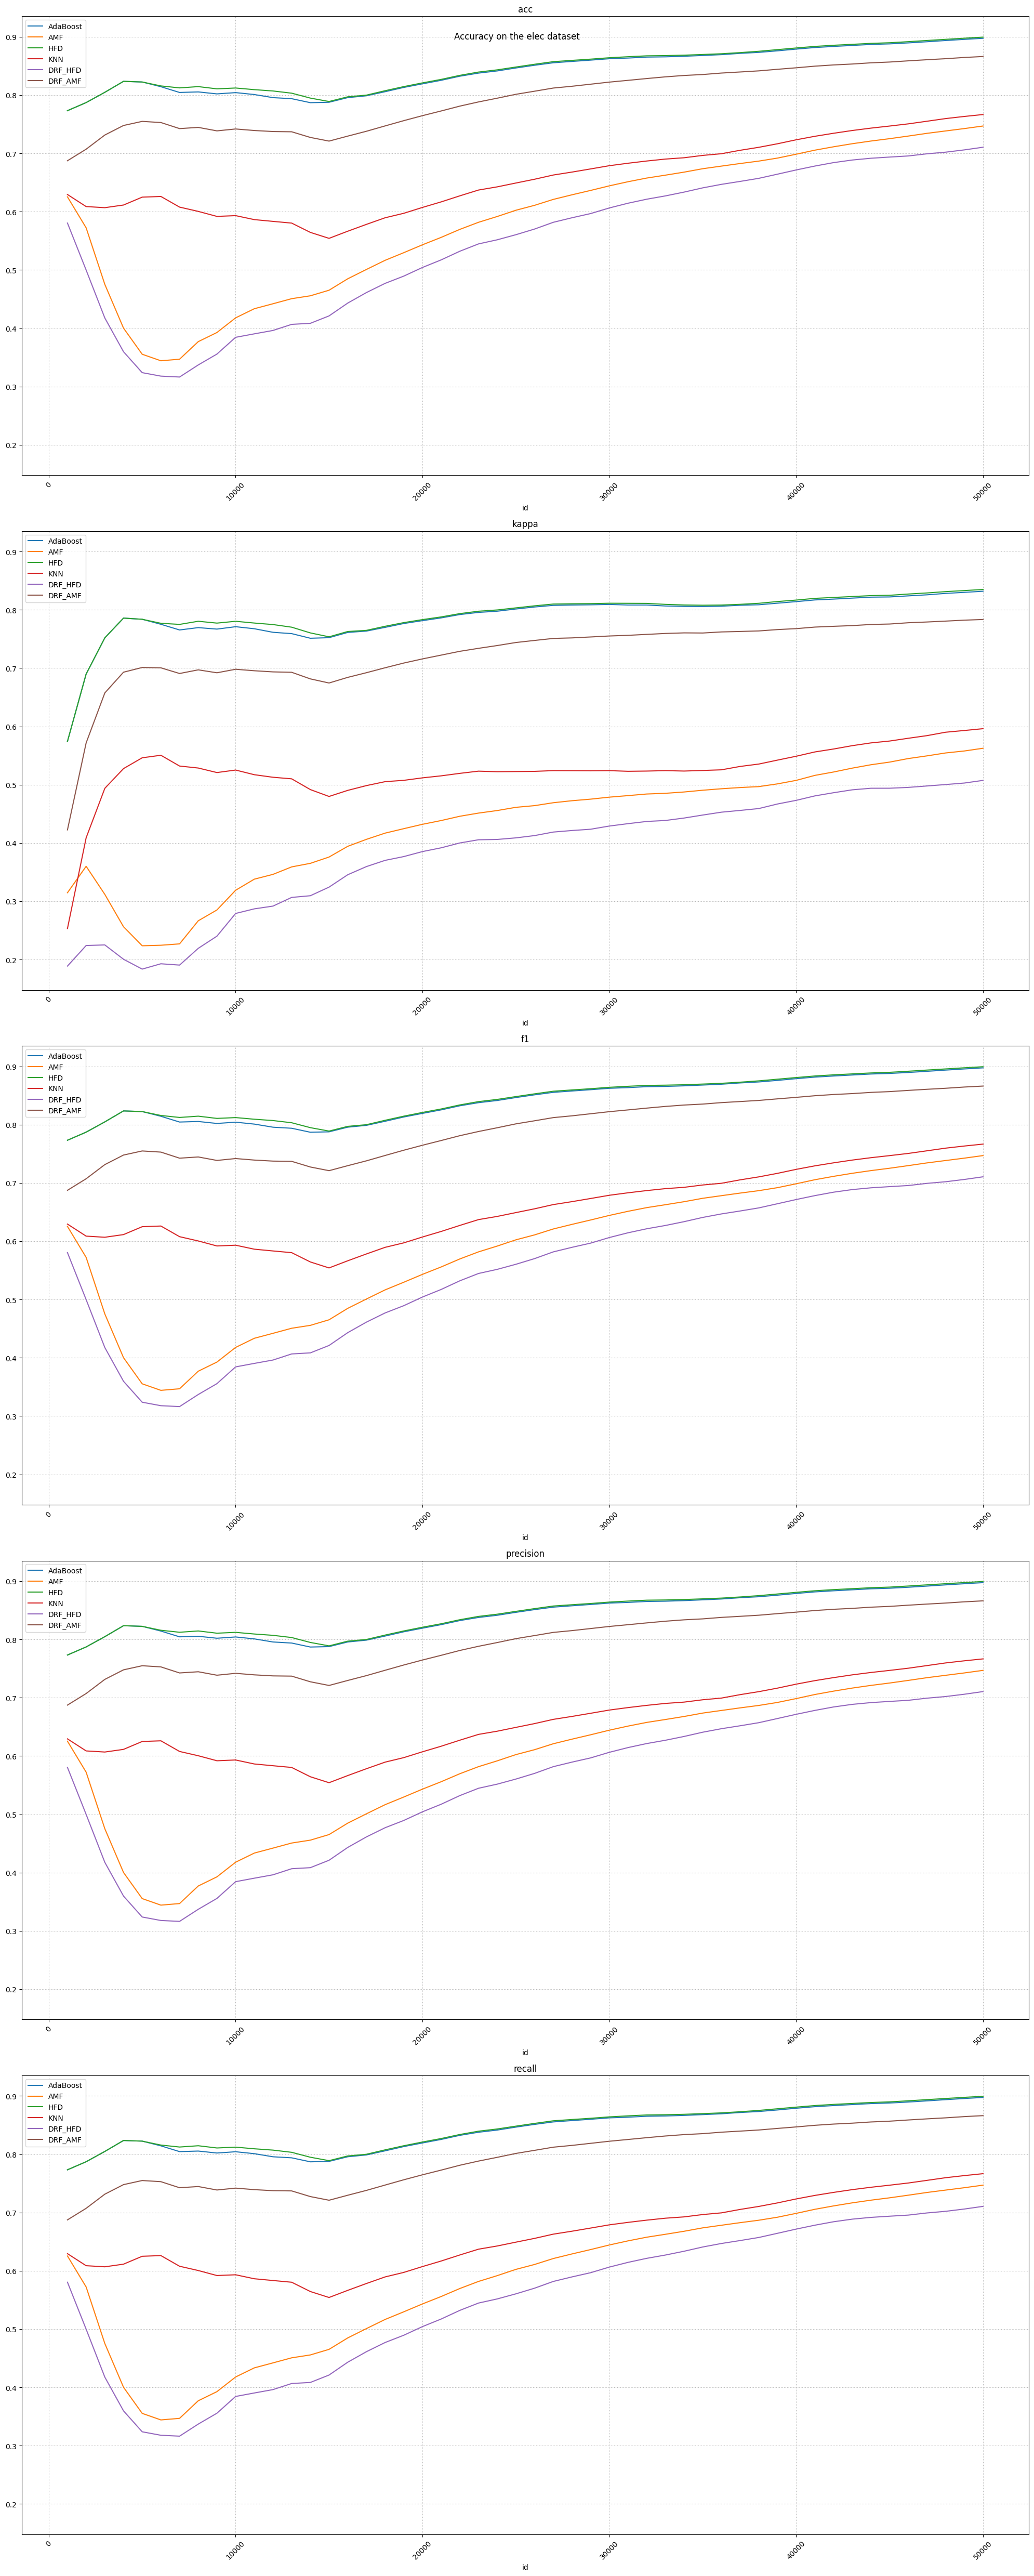

In [26]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = "elec"

df = pd.concat([ada_perf, amf_perf, hfd_perf, knn_perf, drf_perf, drf_amf_perf])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,50), sharey=True)
    for metric, ax in zip(['acc', 'kappa', 'f1', 'precision', 'recall'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["AdaBoost", "AMF", "HFD", "KNN", "DRF_HFD", "DRF_AMF"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page